In [1]:
# IMPORT
from IPython.display import Image, Math

import os
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from utils import *
import numpy as np
import pandas as pd
import pyAgrum
import pyAgrum.skbn as skbn
import pyAgrum.lib.notebook as gnb
import pyAgrum.lib.image as gimg
import pyAgrum.lib.dynamicBN as gdyn
import pyAgrum.causal as pyc
import pyAgrum.causal.notebook as cslnb
import re

In [2]:
# DATA
DAGDIR = '/home/lcastri/git/causalflow/results/BL100_21102024/res.pkl'
INDIR = '/home/lcastri/git/PeopleFlow/utilities_ws/src/RA-L/hrisim_postprocess/csv'
BAGNAME= ['test-obs-21022025']
# BAGNAME= ['noncausal-16022025']
variables = ['TOD', 'R_V', 'R_B', 'C_S', 'PD', 'ELT', 'L', 'EC', 'WP']
starting_t = 100
treatment_len = 100

for bagname in BAGNAME:
    for wp in WP:
        dfs = []
        if wp == WP.PARKING or wp == WP.CHARGING_STATION: continue
        for tod in TOD:
            if tod == TOD.OFF: continue
            files = [f for f in os.listdir(os.path.join(INDIR, "HH/my_nonoise", f"{bagname}", f"{tod.value}"))]
            files_split = [f.split('_') for f in files]
            wp_files = [f for f in files_split if len(f) == 3 and f[2].split('.')[0] == wp.value][0]
            wp_file = '_'.join(wp_files)
            print(f"Loading : {wp_file}")
            filename = os.path.join(INDIR, "HH/my_nonoise", f"{bagname}", f"{tod.value}", wp_file)

            df = pd.read_csv(filename)
            dfs.append(df)
        concat_df = pd.concat(dfs, ignore_index=True)
        break
    
concat_df = concat_df[concat_df['R_V']>=0.05]
    
D = concat_df.drop('WP', axis=1)
D = D.drop('T', axis=1)
D = D.drop('R_X', axis=1)
D = D.drop('R_Y', axis=1)
D = D.drop('G_X', axis=1)
D = D.drop('G_Y', axis=1)
D = D.drop('NP', axis=1)
# D = D.rename(columns={'B_S': 'C_S'})

Loading : test-obs-21022025_H1_door-entrance.csv
Loading : test-obs-21022025_H2_door-entrance.csv
Loading : test-obs-21022025_H3_door-entrance.csv
Loading : test-obs-21022025_H4_door-entrance.csv
Loading : test-obs-21022025_H5_door-entrance.csv
Loading : test-obs-21022025_H6_door-entrance.csv
Loading : test-obs-21022025_H7_door-entrance.csv
Loading : test-obs-21022025_H8_door-entrance.csv
Loading : test-obs-21022025_H9_door-entrance.csv
Loading : test-obs-21022025_H10_door-entrance.csv


/home/lcastri/miniconda3/envs/pyAgrum/lib/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/home/lcastri/miniconda3/envs/pyAgrum/lib/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/home/lcastri/miniconda3/envs/pyAgrum/lib/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


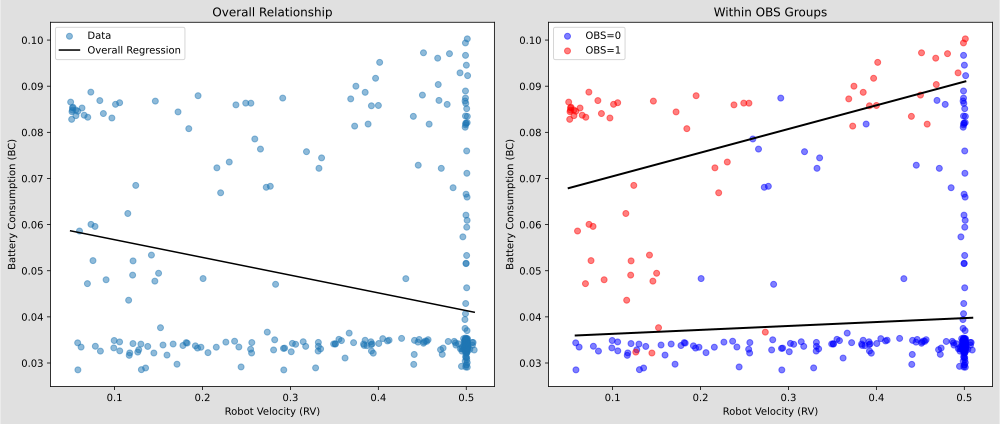

In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

# Generate time series data
np.random.seed(42)


T = D['pf_elapsed_time'].values
OBS = D['OBS'].values
RV = D['R_V'].values
EC = D['EC'].values


# Create DataFrame
df = pd.DataFrame({
    "Time": T,
    "OBS": OBS,
    "RV": RV,
    "EC": EC
})

# -------------------------------------------------
# Outlier Removal using IQR
# -------------------------------------------------
q = 0.01
low_percentile = df["EC"].quantile(q)  # 1st percentile
high_percentile = df["EC"].quantile(1-q)  # 99th percentile

# Filter the data (choose one approach)
# df_filtered = df[(df["EC"] >= lower_bound) & (df["EC"] <= upper_bound)]
df = df[(df["EC"] >= low_percentile) & (df["EC"] <= high_percentile)]  # Uncomment to use percentiles

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# -------------------------------------------------
# 1) Overall Relationship (misleading)
# -------------------------------------------------
ax1.scatter(df["RV"], df["EC"], alpha=0.5, label="Data")
ax1.set_title("Overall Relationship")
ax1.set_xlabel("Robot Velocity (RV)")
ax1.set_ylabel("Battery Consumption (BC)")

# Fit a single linear regression ignoring LOAD
model_all = LinearRegression()
model_all.fit(df[["RV"]], df["EC"])

# Predict across the full RV range
x_all = np.linspace(df["RV"].min(), df["RV"].max(), 100)
y_all = model_all.predict(x_all.reshape(-1, 1))

# Plot the overall regression line
ax1.plot(x_all, y_all, color="black", label="Overall Regression")
ax1.legend()

# -------------------------------------------------
# 2) Within-group relationships (true negative slopes)
# -------------------------------------------------
colors = {0: "blue", 1: "red"}

for load_val in [0, 1]:

    subset = df[df["OBS"] == load_val]
    ax2.scatter(subset["RV"], subset["EC"], color=colors[load_val], alpha=0.5, label=f"OBS={load_val}")

    # Fit regression within this LOAD group
    model_group = LinearRegression()
    model_group.fit(subset[["RV"]], subset["EC"])
    x_g = np.linspace(subset["RV"].min(), subset["RV"].max(), 100)
    y_g = model_group.predict(x_g.reshape(-1, 1))

    # Adjust velocity based on load status
    ax2.plot(x_g, y_g, color='k', linewidth=2)

ax2.set_title("Within OBS Groups")
ax2.set_xlabel("Robot Velocity (RV)")
ax2.set_ylabel("Battery Consumption (BC)")
ax2.legend()

plt.tight_layout()
plt.show()
